In [12]:
from CompleteRunner import load_prediction_model
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
import findspark
findspark.init()
findspark.find()


'H:\\SPARK'

In [13]:
from pyspark.sql import SparkSession

# Initialize SparkSession with necessary configurations
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('Spark') \
    .config("spark.driver.memory", "15g") \
    .config("spark.hadoop.home.dir", "H:/HADOOP/") \
    .config("spark.hadoop.conf.dir", "H:/HADOOP/etc/hadoop/") \
    .getOrCreate()
    
import sys
sys.path.append("G:\Dissertation_Project")

# Get SparkContext from the SparkSession
sc = spark.sparkContext


In [14]:
spark

### PREPROCESSED DATASET

In [15]:
preprocessed_df = spark.read.csv("../Data/Preprocessed_Datasets/DATASET_FINAL_PREPROCESSED.csv", header=True, inferSchema=True)
preprocessed_df.show(10, truncate=False)

+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Convert Conversation Columns into actual Arrays

In [16]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import ast

# UDF to convert string representation of list to actual list
def str_to_array_of_arrays(s):
    # Convert the string to a list and then wrap it inside another list
    return [ast.literal_eval(s)][0]

str_to_array_of_arrays_udf = udf(str_to_array_of_arrays, ArrayType(ArrayType(StringType())))

df = preprocessed_df.withColumn("Attacker_Helper", str_to_array_of_arrays_udf(preprocessed_df["Attacker_Helper"])).withColumn("Victim", str_to_array_of_arrays_udf(preprocessed_df["Victim"]))

df.printSchema()

root
 |-- Conversation_ID: string (nullable = true)
 |-- Attacker_Helper: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Victim: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Conversation_Type: integer (nullable = true)



### Loading the pipeline and transforming the data

In [17]:
from pyspark.ml import PipelineModel
from src.CustonTransformers import FlattenTransformer

pipeline_model_path = "../src/Models/Pipelines/TF-IDF_Pipeline"

pipeline = PipelineModel.load(path=pipeline_model_path)

df_assembled = pipeline.transform(df)

In [20]:
(train_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)
train_data.show(truncate=False)

test_data.count()

+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

665

### Confusion Matrices

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

confusion_matrices = {}
evaluations = {}

for model in ["LogisticRegression_TFIDF", "RandomForest_TFIDF", "GradientBoosted_TFIDF", "NeuralNetwork_TFIDF", "LSTM_NeuralNetwork_TFIDF"]:
    
    
    if (model not in ["NeuralNetwork_TFIDF", "LSTM_NeuralNetwork_TFIDF"]):
        prediction_model = load_prediction_model(model)
        
        predictions = prediction_model.transform(test_data)
        
        metrics = ['accuracy', 'f1', 'weightedPrecision', 'weightedRecall']
        evaluations[model] = {}
        for metric in metrics:
            evaluator = MulticlassClassificationEvaluator(labelCol='Conversation_Type', metricName=metric, predictionCol="Prediction")   
            score = evaluator.evaluate(predictions)
            evaluations[model][metric] = score
            
        # Converting the columns into double
        predictions = predictions.withColumn('Conversation_Type', col('Conversation_Type').cast('double'))
        predictions = predictions.withColumn('Prediction', col('Prediction').cast('double'))

        predictionsAndLabels = predictions.select(['Conversation_Type', 'Prediction']).rdd

        metrics = MulticlassMetrics(predictionAndLabels=predictionsAndLabels)

        conf_matrix = metrics.confusionMatrix().toArray()

        confusion_matrices[model] = conf_matrix
        
    elif model in ["NeuralNetwork_TFIDF", "LSTM_NeuralNetwork_TFIDF"]:
        prediction_model = load_prediction_model(model)
        
        labels = test_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
        labels_numpy_test = np.array(labels)
        
        features = test_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
        features_numpy_test = np.array(features)
        
        if (model == "LSTM_NeuralNetwork_TFIDF"):
            features_numpy_test = np.expand_dims(features_numpy_test, axis=1)
        
        test_loss, test_accuracy, test_precision, test_recall, test_f1score = prediction_model.evaluate(features_numpy_test, labels_numpy_test)
        
        evaluations[model] = {} 
        evaluations[model]['accuracy'] = test_accuracy
        evaluations[model]['f1score'] = test_f1score
        evaluations[model]['precision'] = test_precision
        evaluations[model]['recall'] = test_recall
        evaluations[model]['val_loss'] = test_loss

        
        predictions = prediction_model.predict(features_numpy_test)
        
        predictions_flattened = []
        for prediction in predictions:
            if prediction[0] > 0.5:
                predictions_flattened.append(1)
            else:
                predictions_flattened.append(0)
        
        conf_matrix = confusion_matrix(labels_numpy_test, predictions_flattened)
        
        confusion_matrices[model] = conf_matrix
        

for i in confusion_matrices:
    print(confusion_matrices[i])

<--LOADING PREDICTION MODEL : LogisticRegression_TFIDF , From location : G:\Dissertation_Project\src\Models\Trained_Models\LogisticRegression\bestModel-->

<--LOADING PREDICTION MODEL : RandomForest_TFIDF , From location : G:\Dissertation_Project\src\Models\Trained_Models\RandomForest\bestModel-->

<--LOADING PREDICTION MODEL : GradientBoosted_TFIDF , From location : G:\Dissertation_Project\src\Models\Trained_Models\GradientBoostedTrees\bestModel-->

<--LOADING PREDICTION MODEL : NeuralNetwork_TFIDF , From location : G:\Dissertation_Project\src\Models\Trained_Models\NeuralNetwork_TFIDF\NeuralNetwork_TFIDF.keras-->

21/21 [==============================] - 0s 1ms/step
<--LOADING PREDICTION MODEL : LSTM_NeuralNetwork_TFIDF , From location : G:\Dissertation_Project\src\Models\Trained_Models\LSTM_NeuralNetwork_TFIDF\LSTM_NeuralNetwork_TFIDF.keras-->

21/21 [==============================] - 1s 2ms/step
[[159.  43.]
 [ 43. 420.]]
[[151.  19.]
 [ 51. 444.]]
[[162.  25.]
 [ 40. 438.]]
[[173  

In [10]:
print(evaluations)

{'LogisticRegression_TFIDF': {'accuracy': 0.8706766917293233, 'f1': 0.8706766917293233, 'weightedPrecision': 0.8706766917293233, 'weightedRecall': 0.8706766917293233}, 'RandomForest_TFIDF': {'accuracy': 0.8947368421052632, 'f1': 0.8919674430199682, 'weightedPrecision': 0.8943165400131345, 'weightedRecall': 0.8947368421052632}, 'GradientBoosted_TFIDF': {'accuracy': 0.9022556390977443, 'f1': 0.9011501541650295, 'weightedPrecision': 0.9011276429051731, 'weightedRecall': 0.9022556390977443}, 'NeuralNetwork_TFIDF': {'accuracy': 0.902255654335022, 'f1score': 0.92927086353302, 'precision': 0.9364035129547119, 'recall': 0.9222462177276611, 'val_loss': 0.2734430432319641}, 'LSTM_NeuralNetwork_TFIDF': {'accuracy': 0.8571428656578064, 'f1score': 0.8990434408187866, 'precision': 0.8849372267723083, 'recall': 0.9136068820953369, 'val_loss': 0.3749295473098755}}


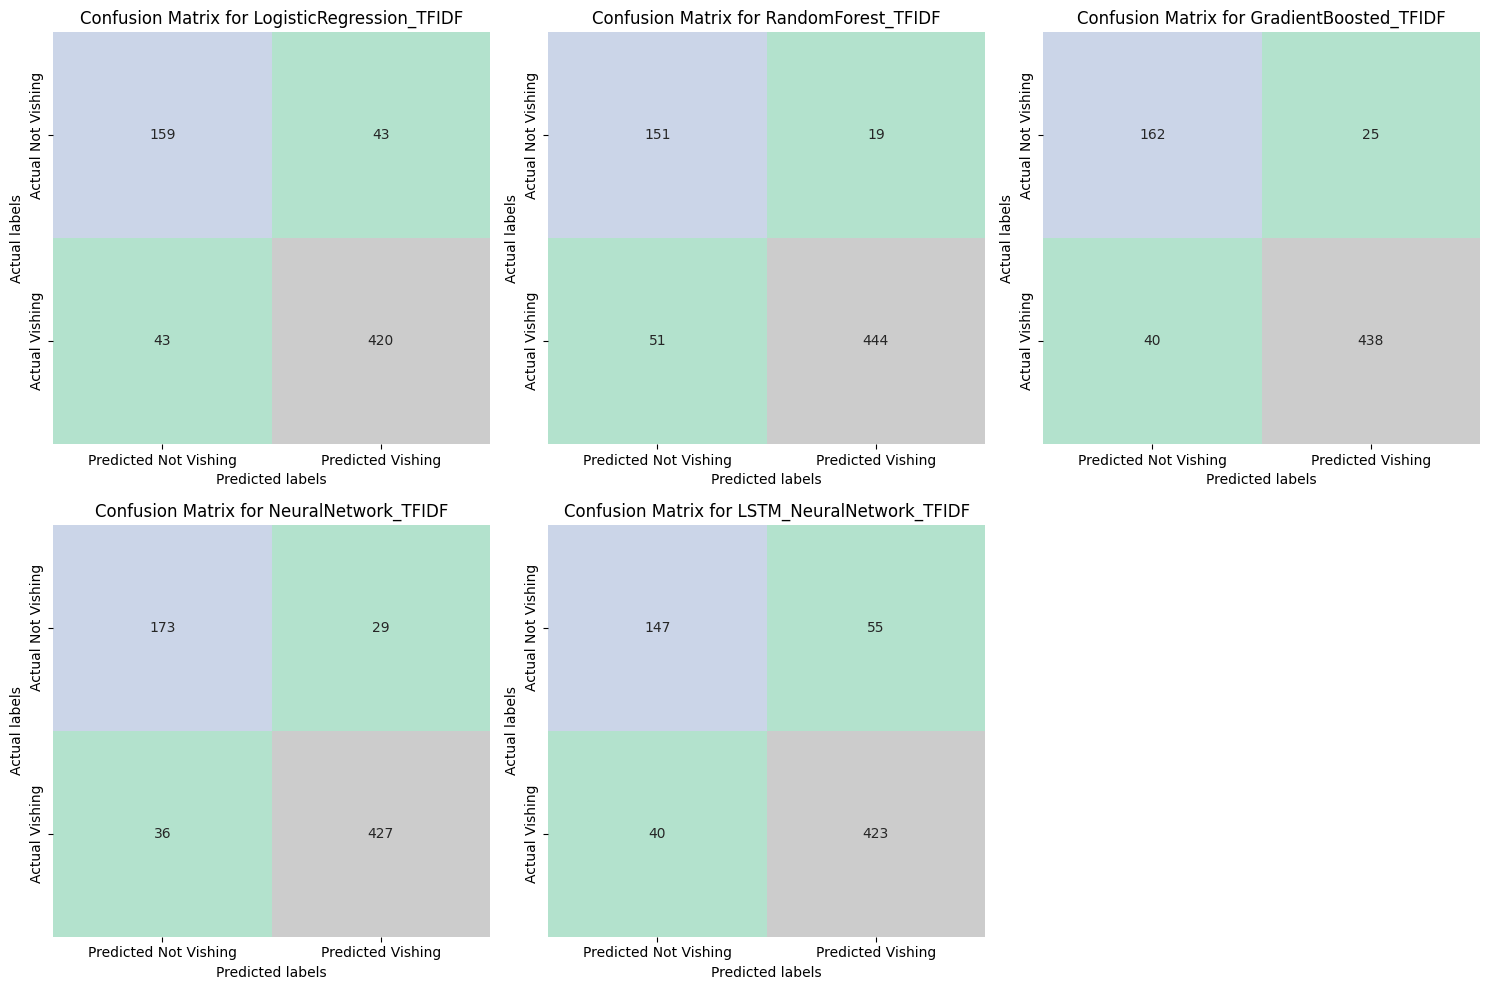

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming confusion_matrices is a dictionary with 5 models
# Create a 2x3 grid of subplots
num_models = len(confusion_matrices)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust for 2 rows and 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Iterate over models and their respective confusion matrices
for idx, (model, matrix) in enumerate(confusion_matrices.items()):
    # Convert the confusion matrix to a pandas DataFrame
    df_cm = pd.DataFrame(matrix, 
                         index=["Actual Not Vishing", "Actual Vishing"],
                         columns=["Predicted Not Vishing", "Predicted Vishing"])
    
    # Plot using Seaborn on the appropriate subplot
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap='Pastel2', ax=axes[idx])
    
    # Add title and format the subplot for clarity
    axes[idx].set_title(f'Confusion Matrix for {model}')
    axes[idx].set_xlabel('Predicted labels')
    axes[idx].set_ylabel('Actual labels')

# Hide the last subplot (bottom right) since we have only 5 models
axes[-1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()